### 导入库函数

In [41]:
import time
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 
import jieba
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score ,roc_curve
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### 读取数据

In [44]:
def get_data(path):  

    df = pd.read_csv(path)
    df_sample = df.sample(n=10000, random_state=42) #随机抽取10000个样本
    corpus = df_sample['Title']
    labels = df_sample['label']
    return corpus, labels  


corpus, labels = get_data('./Data/train.news.csv')     # 获取数据集
print(corpus[0])                # 示例输出
print(labels[0])                
print("总的数据量:", len(labels)) 

中国反腐风刮到阿根廷，这个美到让人瘫痪的女总统，因为8个本子摊上大事了
0
总的数据量: 10000


### 数据预处理

In [45]:
def remove_empty_docs(corpus, labels):  
    '''
    功能：重新整合新闻及标签，去除空白新闻
    zip(corpus, labels),控制同时遍历corpus和labels
    doc.strip(),去除文本首尾空格和换行符，如果有非空字符，返回真
    '''
    filtered_corpus = []  
    filtered_labels = []  
    for doc, label in zip(corpus, labels):  
        if doc.strip():  
            filtered_corpus.append(doc)  
            filtered_labels.append(label)  
  
    return filtered_corpus, filtered_labels 

def load_embeddings(path, dimension=300):
    '''
    功能：加载预训练词向量，构建从词到向量的映射
    dimension=300,表示词向量维度是300
    ''' 
    word_vecs = {} 
    with open(path, 'r', encoding='UTF-8') as f: 
        n, _ = map(int, f.readline().strip().split()) #读取词向量的个数和维度
        for line in f: #遍历文件的每一行，从第二行开始
            parts = line.strip().split() #strip会移除头尾的空白字符，split会将每行按空格分割，parts形如["山峰","0.124","-0.234",...]
            word = ' '.join(parts[:-dimension])  #从parts列表中删除最后300个元素之外的所有元素，然后将其连接，不使用parts[0]是因为有些词可能包含空格，如part[1]也是汉字
            vec = list(map(float, parts[-dimension:])) #将parts列表中最后300个元素转换为浮点数，list是将map的结果转换为列表
            word_vecs[word] = vec #将词到向量的映射存入词典
    return word_vecs #word_vecs形如{"山峰":[0.124,-0.234,...],"河流":[0.234,0.123,...],...}

# 构建词典
word_vecs = load_embeddings('Data/sgns.sogounews.bigram-char')

# 数据清洗
corpus, labels = remove_empty_docs(corpus, labels) 
print(corpus[0])      # 输出处理后的第一封邮件(换行符被处理在字符串中)
print(labels[0])      
print("总的数据量:", len(labels))  

冯小刚还不知道自己是怎么死的！
1
总的数据量: 10000


### 划分数据集

In [46]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3):  
    '''
    功能：划分数据集
    test_size=0.3，测试集30%，训练集70%
    random_state=42，设置随机种子，确保每次切割结果一致
    '''  
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels, test_size = test_data_proportion, random_state=42)  
    return train_X, test_X, train_Y, test_Y

train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(corpus,  labels,  test_data_proportion=0.3)  
print('训练集样本数量：%d，测试样本数量：%d'%(len(train_corpus),len(test_corpus)))
print(train_corpus[101],train_labels[101])
print(test_corpus[3],test_labels[3]) 

训练集样本数量：7000，测试样本数量：3000
中美贸易战后，中国印钞厂70幅内部照曝光，简直亮瞎了！ 0
台湾提出统一条件：一国两区，国名为“中华共和国” 0


### 样本标准化

In [47]:
def text_to_matrix(text, word_vecs, max_words):
    '''
    功能：将标题进行分词，再将词转为词向量(依据已有的预训练词典)
    '''
    words = jieba.lcut(text) #words类似于["山峰","河流"]
    matrix = np.zeros((max_words, 300)) #matrix形如[[0,0,...,0],[0,0,...,0],...]，有40行，每行有300个0
    for i, word in enumerate(words[:max_words]): #word形如"山峰"，i是下标例如7，:max_words是防止越界
        if word in word_vecs: #如果"山峰"在word_vecs中
            matrix[i] = word_vecs[word] #得到"山峰"的词向量，存入matrix的第i行
    return matrix #matrix形如[[0.124,-0.234,...],[0.234,0.123,...],...]，对应"山峰河流"...，如果words较少，后面的行全是0

# 测试标题最大词语组成数量
max_words = 40
print("max_words:",max_words)

# 文本转向量
# X_train类似于[[[Titile1的预训练词向量],[Title1的预训练词向量]],[[Title2的预训练词向量],[Title2的预训练词向量]],[[...],[...]]]
X_train = np.array([text_to_matrix(title, word_vecs, max_words) for title in train_corpus]) # 训练集
y_train = train_labels
X_validation = np.array([text_to_matrix(title, word_vecs, max_words) for title in test_corpus]) #验证集
y_validation = test_labels

#  Numpy数组转换为PyTorch张量，直接用torch.tensor函数
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.long)
print("shape of 4 tensors:",X_train.shape,y_train.shape,X_validation.shape,y_validation.shape)

# 组合拼接新闻标题与标签
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

# DataLoader是一个迭代器，每次迭代会返回一个batch的数据,其中dataset是数据集，batch_size是每个batch的大小，shuffle是是否打乱数据
# for texts, labels in train_loader，其中texts: torch.Size([64, 40, 300])相当于64个标题 。labels: torch.Size([64])相当于64个标签
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=False)#千万不要打乱，否则预测和实际标签无法对应

max_words: 40
shape of 4 tensors: torch.Size([7000, 40, 300]) torch.Size([7000]) torch.Size([3000, 40, 300]) torch.Size([3000])


### 模型

In [60]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)
        #input_dim是输入的特征维度，hidden_dim是隐藏层的维度，n_layers是RNN的层数，batch_first=True表示期待输入的张量形状是(batch, seq, feature)
        self.fc = nn.Linear(hidden_dim, output_dim) #全连接层，将隐藏层的输出映射到输出维度

    def forward(self, x):
        out, hidden = self.rnn(x)
        # out.shape = torch.Size([64, 40, 64])，表示64个标题，每个标题40个词，每个词64维的隐藏层输出
        # hidden.shape = torch.Size([2, 64, 64])，表示2层RNN，每层64个标题，每个标题64维的隐藏层输出
        out = self.fc(out[:, -1, :])
        # out.shape = torch.Size([64, 2])，表示64个标题，每个标题的预测结果
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(1280, 2)

    def forward(self, x):
        # x.shape: torch.Size([64, 40, 300])
        x = x.permute(0, 2, 1)              # x.shape: torch.Size([64, 300, 40])
        x = self.conv1(x)                   # x.shape: torch.Size([64, 64, 40])
        x = F.relu(x)                       # x.shape: torch.Size([64, 64, 40])
        x = self.pool(x)                    # x.shape: torch.Size([64, 64, 20])
        x = x.view(x.size(0), -1)           # x.shape: torch.Size([64, 1280])
        x = self.fc(x)                      # x.shape: torch.Size([64, 2])
        return x

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, hidden = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

# model_RNN = RNNModel(input_dim=300, hidden_dim=64, output_dim=2, n_layers=2)
# model_LSTM = LSTMModel(input_dim=300, hidden_dim=256, output_dim=2, n_layers=2)
# model_CNN = SimpleCNN()
model_GRU = GRUModel(input_dim=300, hidden_dim=128, output_dim=2, n_layers=2)

criterion = nn.CrossEntropyLoss()   # 分类任务用交叉熵作为损失函数
optimizer = optim.Adam(model_GRU.parameters())  # Adam优化器

### 模型训练与评估

In [61]:
def train(model,train_loader):
    model.train()
    start_time = time.time()
    for epoch in range(10):  # 进行多轮训练
        for texts, labels in train_loader:
            optimizer.zero_grad()   # 清除之前的梯度
            outputs = model(texts)  # 前向传播，out.shape = torch.Size([64, 2])，表示64个标题，2表示两个类别
            loss = criterion(outputs, labels)   # 计算损失
            loss.backward()     # 反向传播
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # 梯度规范化，防止出现梯度消失或爆炸
            optimizer.step()    # 更新参数，主要工作之一确实是梯度下降
        use_time = time.time() - start_time
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}, Time: {use_time}')#打印每个epoch的损失值
        start_time = time.time()


def evaluate(model,validation_loader):
    model.eval()
    y_pred = []
    y_true = []
    probabilities = []
    with torch.no_grad():   # 不需要计算梯度
        for texts, labels in validation_loader: 
            outputs = model(texts) 
            _, predicted = torch.max(outputs.data, 1) # 取出每个标题的预测结果中概率最大的那个类别，predicted.shape = torch.Size([64])，形如[1,1,...]
            y_pred.extend(predicted.numpy()) # 将predicted转换为numpy数组，然后加入y_pred
            probs = F.softmax(outputs, dim=1)
            probabilities.extend(probs[:, 1].numpy())
            y_true.extend(labels.numpy())

    # metrics
    precision_0 = precision_score(y_true, y_pred, pos_label=0)
    recall_0 = recall_score(y_true, y_pred, pos_label=0)
    f1_0 = f1_score(y_true, y_pred, pos_label=0)
    precision_1 = precision_score(y_true, y_pred, pos_label=1)
    recall_1 = recall_score(y_true, y_pred, pos_label=1)
    f1_1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probabilities)
    print(f"Precision on Real Label (0): {precision_0}")
    print(f"Recall on Real Label (0): {recall_0}")
    print(f"F1 Score on Real Label (0): {f1_0}")
    print(f"Precision on False Label (1): {precision_1}")
    print(f"Recall on False Label (1): {recall_1}")
    print(f"F1 Score on False Label (1): {f1_1}")
    print(f"Overall Accuracy: {accuracy}")
    print(f"AUC: {auc}")

    # 使用matplotlib绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(y_true, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# 训练
train(model_GRU,train_loader)
# 评估
evaluate(model_GRU,validation_loader)

### 投入测试集

Evaluation on Test Set:
Precision on Real Label (0): 0.9133925703886093
Recall on Real Label (0): 0.9853331793509643
F1 Score on Real Label (0): 0.948
Precision on False Label (1): 0.84125
Recall on False Label (1): 0.4541160593792173
F1 Score on False Label (1): 0.5898334794040315
Overall Accuracy: 0.9077014101173454
AUC: 0.8453267364044711


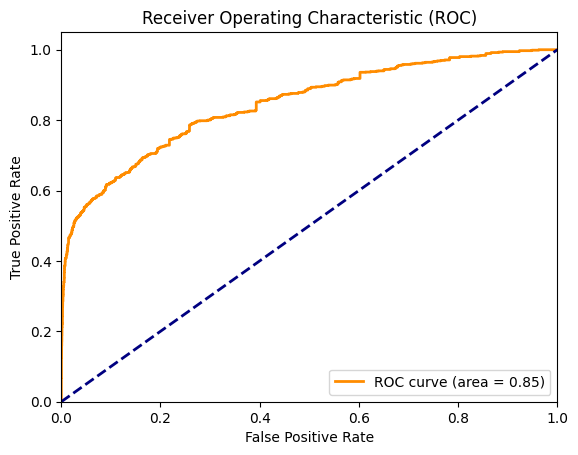

In [59]:
# 加载测试集
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    X = np.array([text_to_matrix(title, word_vecs, max_words) for title in df['Title']])
    y = df['label'].values
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

X_test, y_test = load_dataset('./Data/test.news.csv')
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 在测试集上评估模型
print("Evaluation on Test Set:")
evaluate(model_GRU,test_loader)

# 遍历字典并写入文件
# with open('./Data/usefulWordVec.txt', 'w', encoding='utf-8') as f:
#     for word, vec in word_vecs.items():
#         line = f"{word} {' '.join(map(str, vec))}\n"
#         f.write(line)